# Constructing XICs in LC-MS data, asari prototyping

Docker run on MacOS, using scipy-notebook

docker run -v /Users/shuzhao/bulk:/home/jovyan -p 8888:8888 jupyter/scipy-notebook

Shuzhao, 2021-12-7

In [1]:
!pip install pyopenms

In [4]:
import os
from collections import namedtuple
from itertools import combinations
from operator import itemgetter

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy.signal import find_peaks 

from pyopenms import *

In [189]:
testfile = 'iPSC_mTOR/pos/MG_20211022_011.mzML'
#testfile = 'bulk/MT_20211012_027.mzML'

chromfile = 'iPSC_mTOR/pos/MG_20211022_011_chrom.mzML'  # by OpenMS

exp = MSExperiment()
MzMLFile().load(testfile, exp)
# how many spectra in this file
exp.getNrSpectra()

783

In [190]:
# get regions
def get_thousandth_regions(ms_expt, mz_tolerance_ppm=5, min_intensity=100, min_timepoints=5):
    '''
    Process all LC-MS spectral data into flexible bins by units of 0.001 amu.
    mz_tolerance_ppm: m/z tolerance in part-per-million. Used to seggregate m/z regsions here.
    ms_expt: pyopenms MSExperiment instance, loaded with LC-MS data.
    min_intensity: minimal intentsity value, needed because some instruments keep 0s 
    min_timepoints: minimal consecutive scans to be considered real signal.
    
    Return: a list of flexible bins
    '''
    def __rough_check_consecutive_scans__(datatuples, check_max_len=20, gap_allowed=2, min_timepoints=min_timepoints):
        # a list of data points in format of (mz_int, scan_num, intensity_int)
        if len(datatuples) < check_max_len:
            min_check_val = gap_allowed + min_timepoints -1 # step is 4 in five consecutive values without gap
            rts = sorted([x[1] for x in datatuples])
            steps = [rts[ii]-rts[ii-min_timepoints+1] for ii in range(min_timepoints-1, len(rts))]
            if min(steps) > min_check_val:
                return False
            else:
                return True
        else:
            return True
            
    tol_ = 0.000001 * mz_tolerance_ppm
    number_spectra = ms_expt.getNrSpectra()
    alldata = []
    for ii in range(number_spectra):
        for (mz, intensity) in zip(*ms_expt[ii].get_peaks()):
            if intensity > min_intensity:
                alldata.append((mz, ii, int(intensity)))

    print("extracted %d valide data points." %len(alldata))
    
    mzTree = {}
    for x in alldata:
        ii = int(x[0]*1000)
        if ii in mzTree:
            mzTree[ii].append(x)
        else:
            mzTree[ii] = [x]

    del alldata
    ks = sorted([k for k,v in mzTree.items() if len(v) >= min_timepoints]) # ascending order
    bins_of_bins = []
    tmp = [ks[0]]
    for ii in range(1, len(ks)):
        _delta = ks[ii] - ks[ii-1]
        # merge adjacent bins if they are next to each other or within ppm tolerance
        if _delta==1 or _delta < tol_ * ks[ii]:
            tmp.append(ks[ii])
        else:
            bins_of_bins.append(tmp)
            tmp = [ks[ii]]

    bins_of_bins.append(tmp)
    good_bins = []
    for bin in bins_of_bins:
        datatuples = []
        for b in bin:
            datatuples += mzTree[b]
        # check the presence of min consecutive RT in small traces, to filter out more noises
        # e.g. in this datafile, 5958 reduced to 4511 traces
        if __rough_check_consecutive_scans__(datatuples):
            good_bins.append(datatuples)
    
    del mzTree
    return good_bins


In [191]:
good_bins = get_thousandth_regions(exp, mz_tolerance_ppm=5, min_intensity=100, min_timepoints=5)
print(len(good_bins))

extracted 725663 valide data points.
4511


In [192]:
# sorted(good_bins[995])[:20] # , key=itemgetter(1)
good_bins[995][:20]

[(189.13832092285156, 27, 25656),
 (189.1387939453125, 48, 28787),
 (189.13845825195312, 51, 19501),
 (189.13856506347656, 65, 9076),
 (189.1384735107422, 107, 12805),
 (189.13839721679688, 129, 16645),
 (189.1388397216797, 144, 12606),
 (189.13865661621094, 146, 17190),
 (189.1381378173828, 234, 13025),
 (189.13839721679688, 277, 7165),
 (189.13844299316406, 294, 8015),
 (189.13851928710938, 342, 10542),
 (189.13845825195312, 360, 9889),
 (189.138427734375, 446, 10193),
 (189.1385498046875, 492, 8046),
 (189.1385955810547, 494, 7884),
 (189.1385040283203, 536, 9403),
 (189.13853454589844, 558, 9013),
 (189.13864135742188, 563, 10289),
 (189.1385955810547, 586, 11970)]

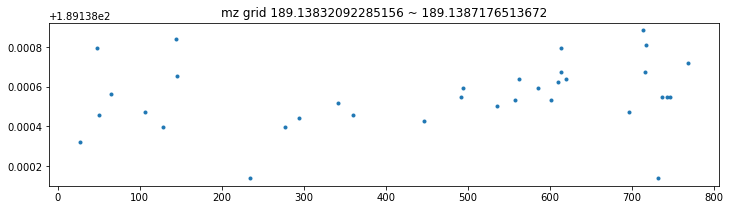

In [193]:
def plot_mz_grid(bin_num):
    plt.figure(figsize=(12,3))
    X = [x[1] for x in good_bins[bin_num]]
    Y = [x[0] for x in good_bins[bin_num]]
    plt.plot(X,Y, '.')
    plt.title('mz grid ' + str(good_bins[bin_num][0][0]) + ' ~ ' + str(good_bins[bin_num][-1][0]))

plot_mz_grid(995)

## Define m/z peaks in each bin, then extract massTrace

Count frequency of vlaues in each m/z sub_bin

5 ppm is 0.0005 for m/z=100, but 0.005 for m/z=1000.

Do bins at the size of mz_tolerance/5, take central 3 bins, and extend both ends until local minimium is reached.

Take cental bin's m/z value to represent the whole mass trace. Sum intensities per scan. This is a massTrace.

RT length can be controlled within.

In [194]:
print([len(b) for b in good_bins[-80:-70]])

[15, 21, 16, 6, 10, 9, 9, 6, 344, 6]


In [195]:
t = good_bins[-72]
t.sort()
n = (t[-1][0]-t[0][0])/(t[0][0]*0.000001)
print(n)
np.histogram([x[0] for x in good_bins[-72]], int(n))

5.977137719909424


(array([ 26,  93, 126,  76,  23]),
 array([898.60632324, 898.60739746, 898.60847168, 898.6095459 ,
        898.61062012, 898.61169434]))

In [196]:
find_peaks([  26,  93, 126,  76,  23])

(array([2]), {})

In [197]:
# find example width > 20 ppm
for ii in range(4000,4511):
    m = [x[0] for x in good_bins[ii]]
    if max(m)-min(m) > 0.000010 * m[0]:
        print((ii, len(m)))

(4015, 676)
(4016, 273)
(4152, 623)
(4155, 272)
(4177, 285)
(4222, 98)
(4245, 76)


In [198]:
ii = 4015
t = good_bins[ii]
t.sort()
n = (t[-1][0]-t[0][0])/(t[0][0]*0.000001)
print(n)
np.histogram([x[0] for x in good_bins[ii]], int(n))

11.726070885532627


(array([  8,   3,  11,  24,  31,  50,  81, 164, 269,  28,   7]),
 array([723.50634766, 723.50711892, 723.50789018, 723.50866144,
        723.50943271, 723.51020397, 723.51097523, 723.51174649,
        723.51251776, 723.51328902, 723.51406028, 723.51483154]))

### Do some performance comparison of finding local maxima

In [199]:
import time
from scipy.signal import argrelextrema

a = np.array([  8,  33,  11,  24,  31,  50,  81, 164, 269,  28,   7, 18, 18, 1])

In [200]:
find_peaks(a)
# not getting rising edges as argrelextrema does, but it's okay for XIC purpose

(array([ 1,  8, 11]), {})

In [201]:
find_peaks([  18,  11,  11, ])

(array([], dtype=int64), {})

In [202]:
find_peaks([  8,  33,  11,  24,  31,  50,  180, 164, 269,  28,   7, 18], distance=3)

(array([1, 8]), {})

In [203]:
argrelextrema(a, np.greater_equal)

(array([ 1,  8, 11, 12]),)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f988a42eda0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f988ba86b00>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f98819b8908>,
 'medians': [<matplotlib.lines.Line2D at 0x7f988ba86400>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f988ba86710>,
 'means': []}

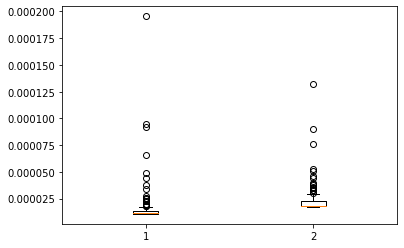

In [204]:
t1, t2 = [], []

for ii in range(100):
    t = time.process_time()
    find_peaks(a)
    t1.append(time.process_time() - t)
    
for ii in range(100):
    t = time.process_time()
    argrelextrema(a, np.greater_equal)
    t2.append(time.process_time() - t)

plt.boxplot([t1, t2])

**conclusion: argrelextrema may be faster but potential complication of treating equals; use find_peaks for now**

In [205]:
hist = np.array([  8,   33,  11,  24,  31,  50,  81, 164, 269,  28,   7])
[0] + [hist[:ii].sum() for ii in range(1,11+1)]

[0, 8, 41, 52, 76, 107, 157, 238, 402, 671, 699, 706]

In [206]:
def extract_single_trace(bin, gap_allowed=2, min_timepoints=5):
    mz = np.mean([x[0] for x in bin])
    bin.sort(key=itemgetter(1))   # sort by increasing RT (scan number)
    traces = []
    tmp = [bin[0]]
    for ii in range(1,len(bin)):
        _d = bin[ii][1] - bin[ii-1][1]
        if _d > gap_allowed:
            traces.append(tmp)
            tmp = [bin[ii]]
        else:
            tmp.append(bin[ii])
    traces.append(tmp)
    traces = [t for t in traces if len(t) >= min_timepoints]
    # filtered by consecutive RT scans. Now integrate intensity per RT
    XICs = []
    for tt in traces:
        _d = {}
        for r in tt: 
            _d[r[1]] = 0
        for r in tt:     # this gets max intensity on the same RT scan
            _d[r[1]] = max(r[2], _d[r[1]])
        rtlist = sorted(list(_d))
        intensities = [_d[x] for x in rtlist]
        XICs.append(( mz, rtlist, intensities ))
    
    return XICs


def sub_bin_to_massTraces(bin_data_tuples, mz_tolerance_ppm=5, gap_allowed=2, min_timepoints=5):
    '''
    input a flexible bin by units of 0.001 amu, in format of [(mz_int, scan_num, intensity_int), ...].
    
    '''
    bin_data_tuples.sort()   # by m/z, ascending
    mz_range = bin_data_tuples[-1][0] - bin_data_tuples[0][0]
    mz_tolerance = bin_data_tuples[0][0] * 0.000001 * mz_tolerance_ppm   
    if mz_range < mz_tolerance:
        return extract_single_trace(bin_data_tuples, gap_allowed, min_timepoints)
    else:
        num_steps = int(5*mz_range/mz_tolerance)     # step in 1/5 mz_tolerance
        hist, bin_edges = np.histogram([x[0] for x in bin_data_tuples], num_steps)
        # example hist: array([  8,   33,  11,  24,  31,  50,  81, 164, 269,  28,   7])
        hist_starts = [0] + [hist[:ii].sum() for ii in range(1,num_steps+1)]
        # find_peaks returns array([ 1, 8]), {}. distance=3 because it's edge of tolerance
        peaks, _ = find_peaks(hist, distance=3)
        if peaks.any():
            XICs = []
            for p in peaks:
                left = max(0, p-2)
                right = min(p+3, num_steps)
                XICs += extract_single_trace(bin_data_tuples[hist_starts[left]: hist_starts[right]], gap_allowed, min_timepoints)
            return XICs
        else:
            peak = np.argmax(hist)  # if find_peaks fails, get position of max value
            left = max(0, peak-2)
            right = min(peak+3, num_steps)
            return extract_single_trace(bin_data_tuples[hist_starts[left]: hist_starts[right]], gap_allowed, min_timepoints)
    
    

In [242]:
def plot_xics(xics):
    if xics:
        plt.figure(figsize=(12,4))
        for x in xics:
            plt.plot(x[1], x[2], '.')
        plt.title('asari ' + str(x[0]))
    else:
        print("[]")

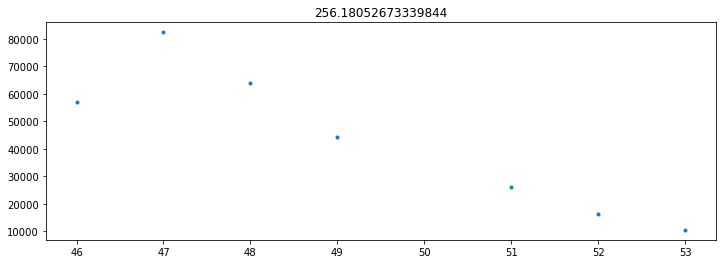

In [208]:
# print(len(  good_bins[550]  ))
xics = sub_bin_to_massTraces(good_bins[1777])
plot_xics(xics)

**To compare with chromatograms extracted by OpenMS**

In [216]:
# modified from asari
def _get_masstraces_from_chromatogram_file_(input_file):
    '''
    Get chromatograms, via pyOpenMS functions (only used in this function). 
    An mzML file of chromatograms (i.e. EIC or XIC, or mass trace). Currently using a MassTrace file produced by FeatureFinderMetabo (OpenMS). 
    min_intensity_threshold: minimal intensity requirement for a mass trace to be considered. Default value 10,000 is lenient in our Orbitrap data.
    Updates self.dict_masstraces, a dict of list of MassTrace objects, indexed by str(round(mz,6))
    '''
    dict_masstraces = {}
    exp = MSExperiment()                                                                                          
    MzMLFile().load(input_file, exp)
    for chromatogram in exp.getChromatograms():
        mz = chromatogram.getPrecursor().getMZ()
        _low, _high = 80, 1000
        if _low < mz < _high:
            mz_str = str(round(mz,4))
            RT, INTS = chromatogram.get_peaks() 
            if INTS.max() > 100:
                if mz_str in dict_masstraces:
                    dict_masstraces[mz_str].append((RT, INTS))
                else:
                    dict_masstraces[mz_str] = [(RT, INTS)]

    print("\nProcessing %s, found %d mass traces." %(input_file, len(dict_masstraces)))
    return dict_masstraces


In [217]:
otraces = _get_masstraces_from_chromatogram_file_(chromfile)


Processing iPSC_mTOR/pos/MG_20211022_011_chrom.mzML, found 6394 mass traces.


In [227]:
wanted = [   730.538, 548.3007, 496.3398, 531.2741, 704.5223, 261.0878, 732.5535, 482.3605, 336.326, 688.5204, 
          332.3311, 338.3416, 138.0548, 878.5747, 674.4623, 430.3889, 950.6347, 904.5903, 684.2026, 660.5771, 
          160.0368, 576.3953, 174.0137, 474.3273, 488.0469, 688.6082, 241.1016, 395.2766, 430.3011, 392.0282, 
          532.4574, 924.2691, 461.3112, 422.3838, 537.1431, 376.3693, 818.6198, 227.9751]

def plot_otrace(m, otraces):
    trace = otraces.get(str(m), [])
    plt.figure(figsize=(12,4))
    for x in trace:
        plt.plot(x[0], x[1], '.')
    plt.title(m)
    

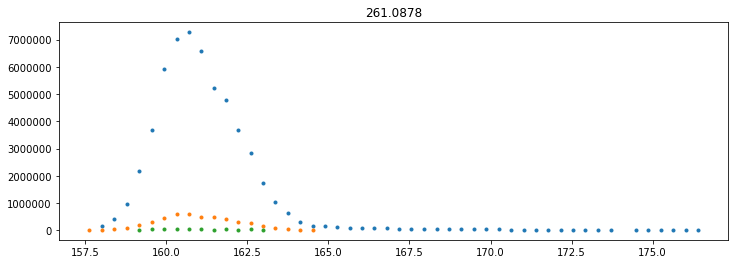

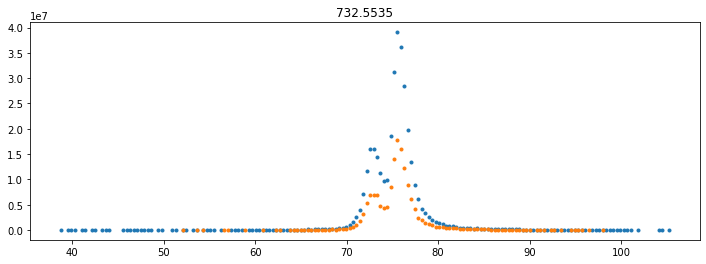

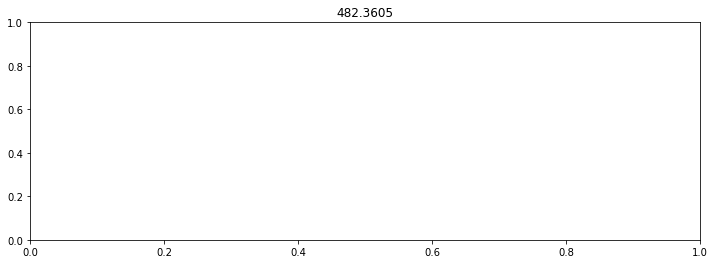

In [241]:
# This is from OpenMS extracted chromatograms
for x in wanted[5:8]:
    plot_otrace(x, otraces)

In [238]:
# find closest bin and plot the xics
def plot_bin(m, good_bins):
    deltas = sorted([(abs(m-x[0][0]), x) for x in good_bins])
    plot_xics(sub_bin_to_massTraces( deltas[0][1] ))

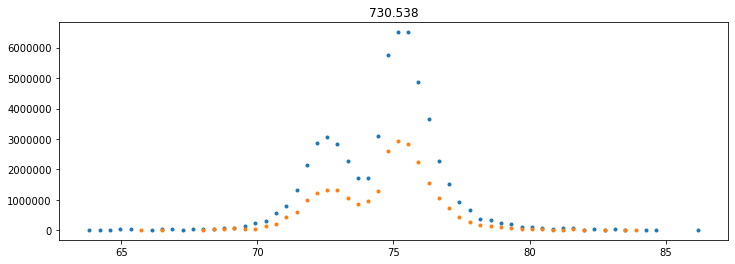

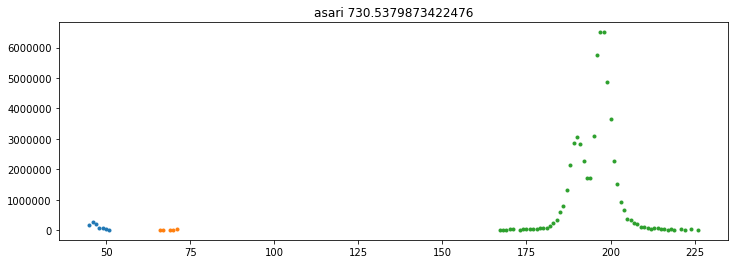

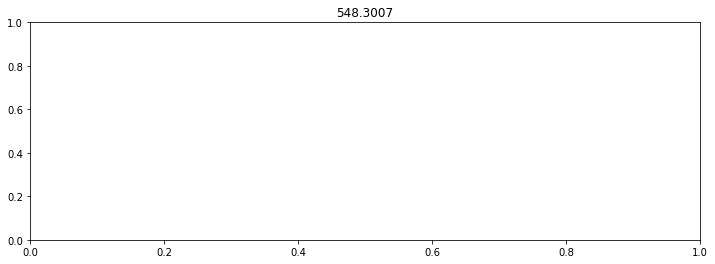

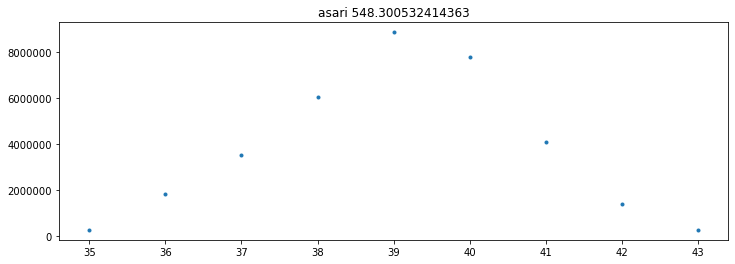

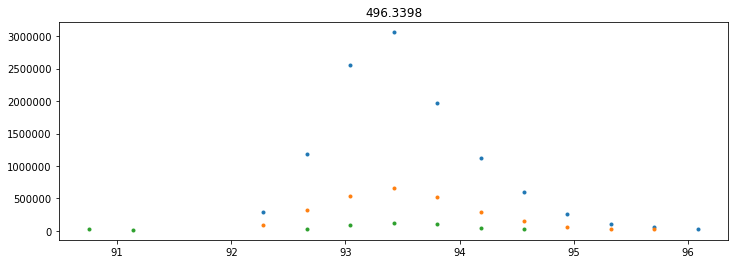

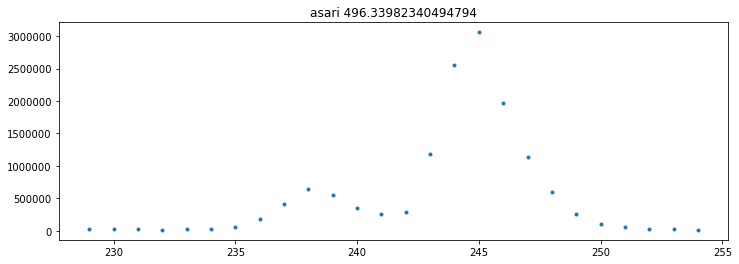

In [243]:
# side-by-side
for x in wanted[:3]:
    plot_otrace(x, otraces)
    plot_bin(x, good_bins)


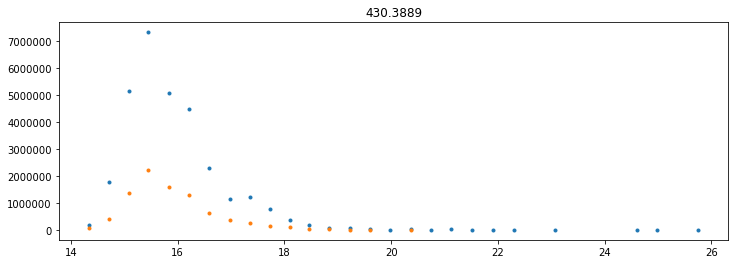

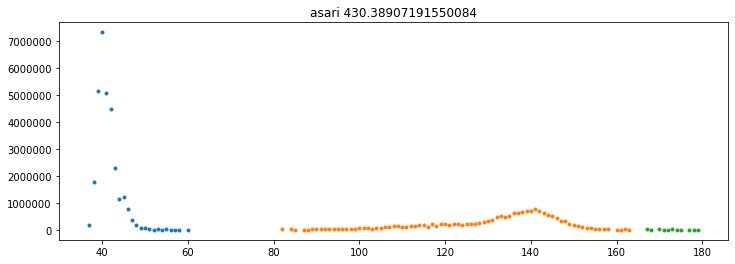

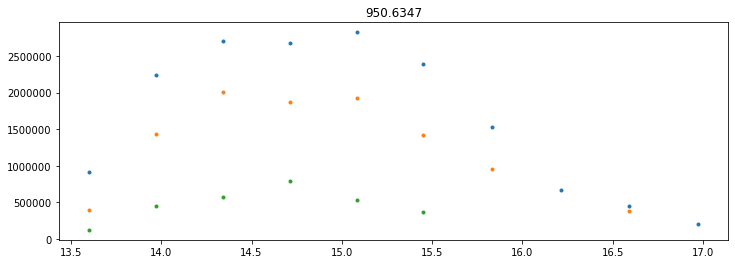

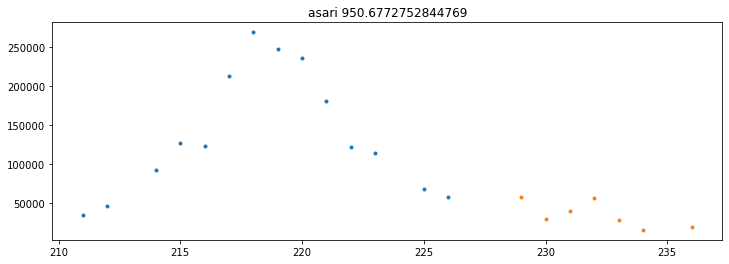

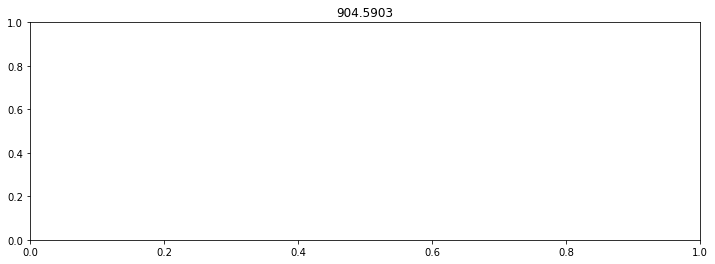

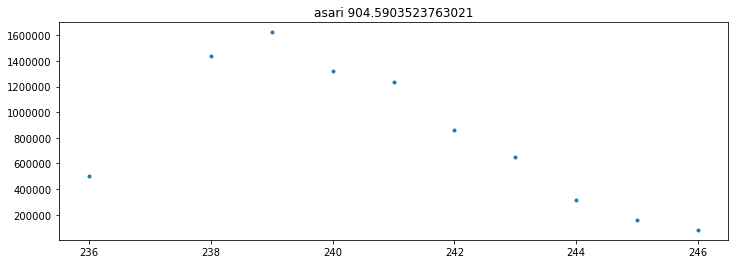

In [245]:
for x in wanted[15:18]:
    plot_otrace(x, otraces)
    plot_bin(x, good_bins)

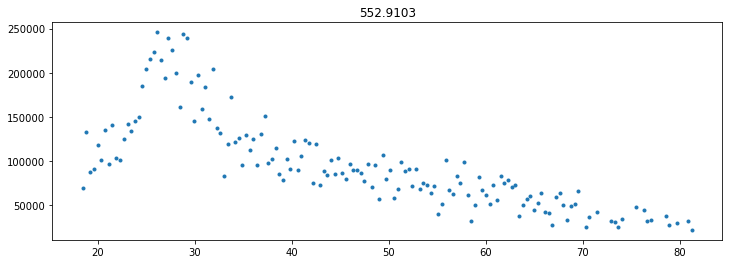

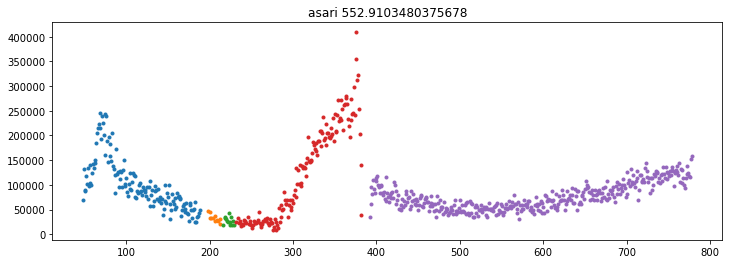

In [247]:
plot_otrace(552.9103, otraces)
plot_bin(552.9103, good_bins)

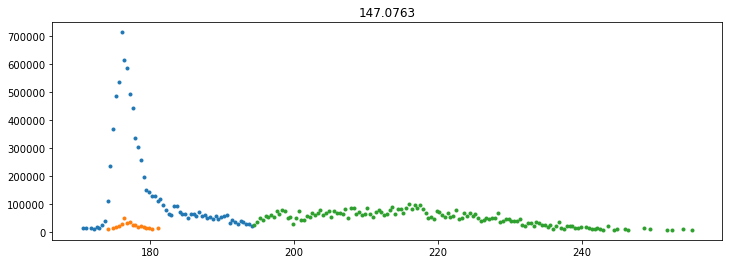

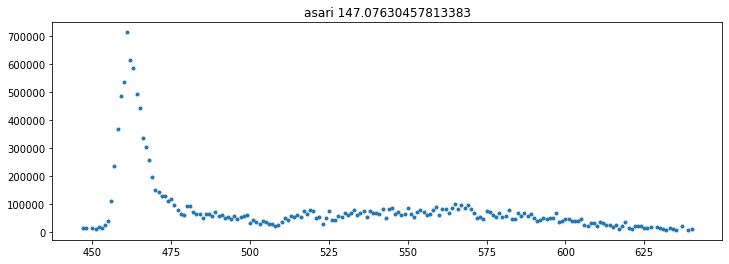

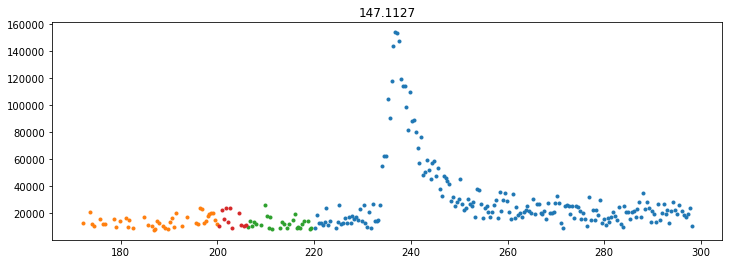

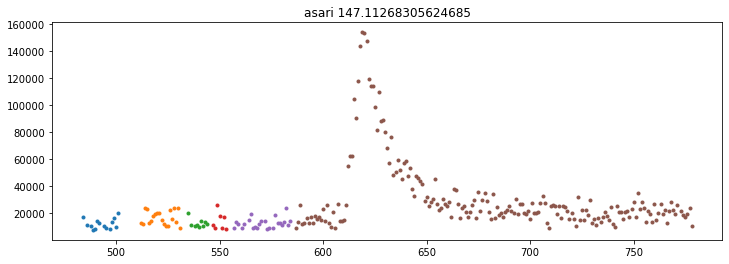

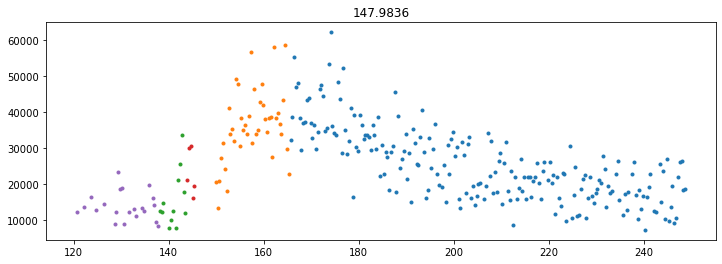

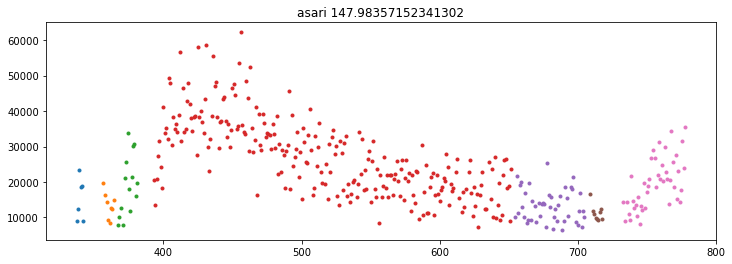

In [249]:
test3 = [147.0763, 147.1127, 147.9836]
for x in test3:
    plot_otrace(x, otraces)
    plot_bin(x, good_bins)

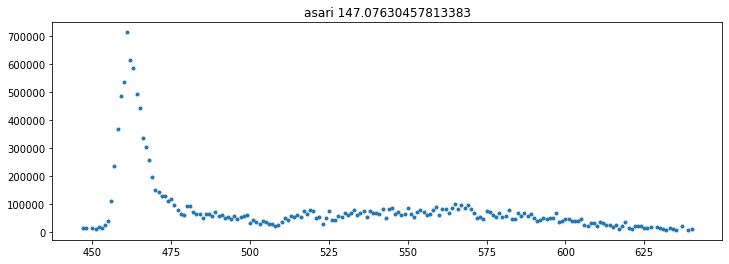

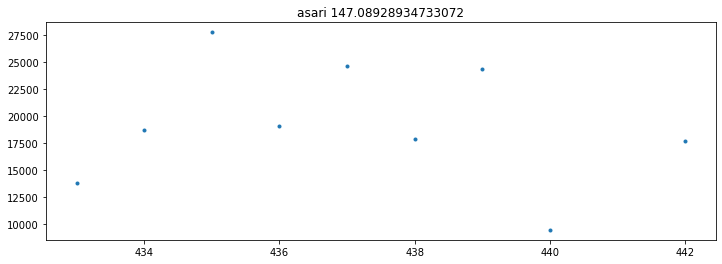

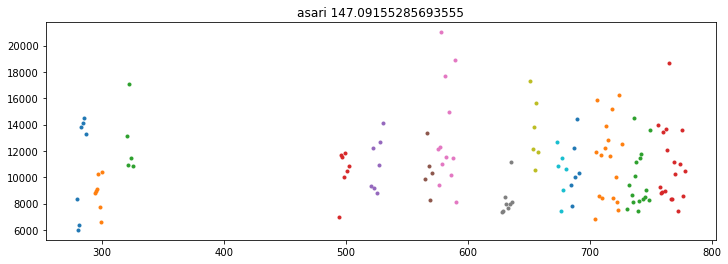

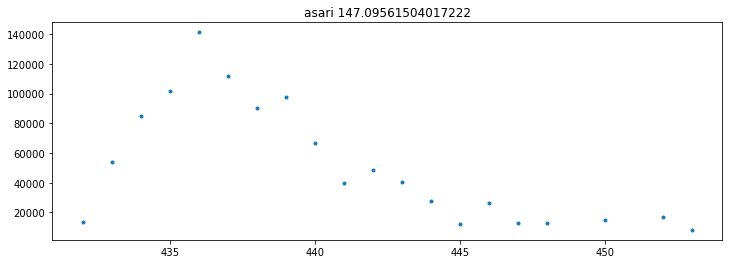

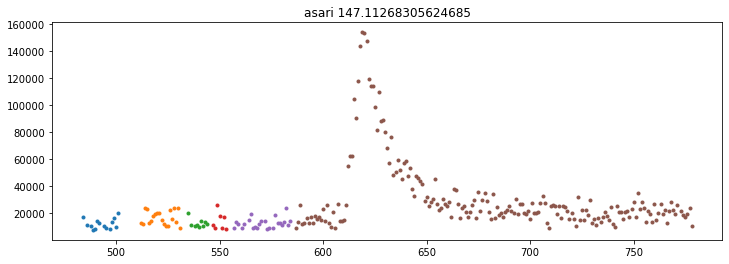

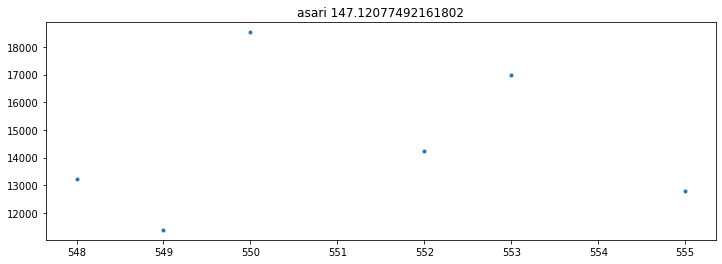

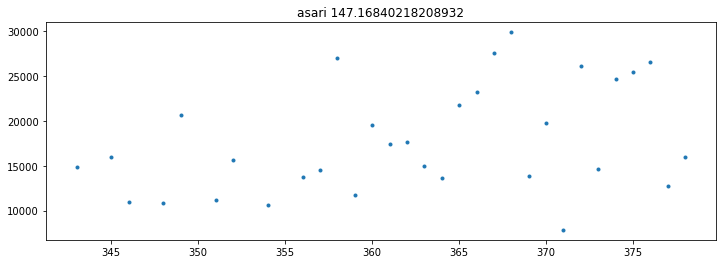

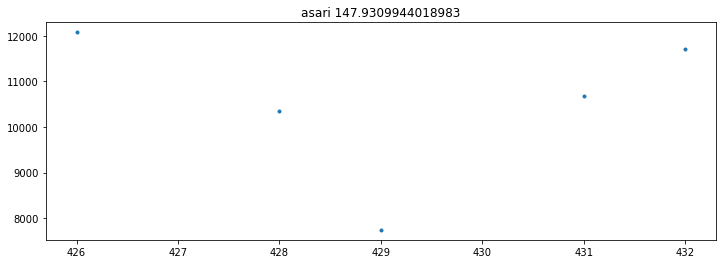

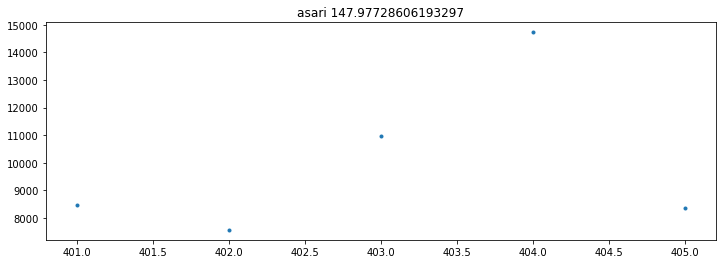

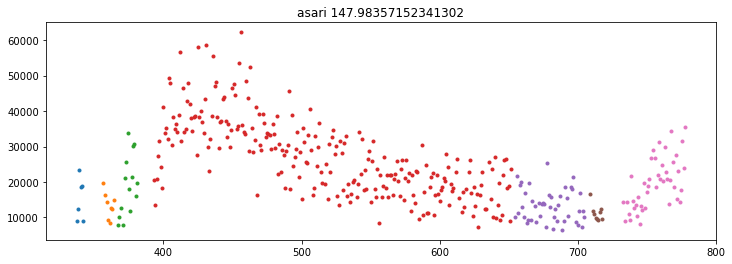

In [248]:
for ii in range(450,460):
    plot_xics(sub_bin_to_massTraces(good_bins[ii]))

## Summary

The asari XICs are not worse than what's from OpenMS.

Moving into asari code now.